# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-3]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.251930 | Test Loss: 1.684128 | Test Accuracy: 0.772578, 0.575949
Step 2 | Training Loss: 0.198299 | Test Loss: 1.522203 | Test Accuracy: 0.770582, 0.571814
Step 3 | Training Loss: 0.263287 | Test Loss: 1.476762 | Test Accuracy: 0.775861, 0.581603
Step 4 | Training Loss: 0.196318 | Test Loss: 1.371923 | Test Accuracy: 0.768054, 0.575359
Step 5 | Training Loss: 0.174296 | Test Loss: 1.398556 | Test Accuracy: 0.779764, 0.590211
Step 6 | Training Loss: 0.378598 | Test Loss: 1.352865 | Test Accuracy: 0.761267, 0.607342
Step 7 | Training Loss: 0.168910 | Test Loss: 1.427429 | Test Accuracy: 0.724627, 0.564894
Step 8 | Training Loss: 0.272406 | Test Loss: 1.473513 | Test Accuracy: 0.726002, 0.581941
Step 9 | Training Loss: 0.143086 | Test Loss: 1.437613 | Test Accuracy: 0.738201, 0.626414
Step 10 | Training Loss: 0.622775 | Test Loss: 1.523667 | Test Accuracy: 0.708659, 0.554008
Step 11 | Training 

Step 29 | Training Loss: 0.495754 | Test Loss: 1.632422 | Test Accuracy: 0.757541, 0.549451
Step 30 | Training Loss: 1.061050 | Test Loss: 1.580853 | Test Accuracy: 0.762287, 0.562279
Step 1 | Training Loss: 0.423384 | Test Loss: 1.575926 | Test Accuracy: 0.760557, 0.565401
Step 2 | Training Loss: 0.406078 | Test Loss: 1.573962 | Test Accuracy: 0.759759, 0.562532
Step 3 | Training Loss: 0.559462 | Test Loss: 1.573751 | Test Accuracy: 0.760424, 0.565148
Step 4 | Training Loss: 0.856697 | Test Loss: 1.571843 | Test Accuracy: 0.760468, 0.562194
Step 5 | Training Loss: 0.343219 | Test Loss: 1.572030 | Test Accuracy: 0.762642, 0.566329
Step 6 | Training Loss: 0.726365 | Test Loss: 1.569305 | Test Accuracy: 0.762154, 0.564388
Step 7 | Training Loss: 0.513165 | Test Loss: 1.566423 | Test Accuracy: 0.763263, 0.567257
Step 8 | Training Loss: 0.471732 | Test Loss: 1.566140 | Test Accuracy: 0.766324, 0.573587
Step 9 | Training Loss: 0.605587 | Test Loss: 1.564846 | Test Accuracy: 0.767388, 0.5734

Step 26 | Training Loss: 0.180412 | Test Loss: 1.664971 | Test Accuracy: 0.725027, 0.694008
Step 27 | Training Loss: 0.396400 | Test Loss: 1.654334 | Test Accuracy: 0.724051, 0.689451
Step 28 | Training Loss: 0.522599 | Test Loss: 1.655494 | Test Accuracy: 0.725914, 0.694768
Step 29 | Training Loss: 0.422681 | Test Loss: 1.656881 | Test Accuracy: 0.727910, 0.697722
Step 30 | Training Loss: 1.180753 | Test Loss: 1.657659 | Test Accuracy: 0.730216, 0.700084
Current Layer Attributes - epochs:30 hidden layers:2 features count:32
Step 1 | Training Loss: 0.352200 | Test Loss: 1.612791 | Test Accuracy: 0.787438, 0.599072
Step 2 | Training Loss: 0.432030 | Test Loss: 1.569022 | Test Accuracy: 0.771868, 0.566582
Step 3 | Training Loss: 0.571413 | Test Loss: 1.550297 | Test Accuracy: 0.780429, 0.584304
Step 4 | Training Loss: 0.338900 | Test Loss: 1.539689 | Test Accuracy: 0.821549, 0.665907
Step 5 | Training Loss: 0.423262 | Test Loss: 1.771863 | Test Accuracy: 0.690161, 0.459662
Step 6 | Train

Step 17 | Training Loss: 1.139669 | Test Loss: 1.766526 | Test Accuracy: 0.864532, 0.764051
Step 18 | Training Loss: 0.609458 | Test Loss: 1.785339 | Test Accuracy: 0.835078, 0.744557
Step 19 | Training Loss: 0.567248 | Test Loss: 1.935606 | Test Accuracy: 0.858588, 0.759241
Step 20 | Training Loss: 0.601546 | Test Loss: 1.975192 | Test Accuracy: 0.834679, 0.746329
Step 21 | Training Loss: 0.739352 | Test Loss: 2.091836 | Test Accuracy: 0.837385, 0.737300
Step 22 | Training Loss: 0.623836 | Test Loss: 1.793033 | Test Accuracy: 0.818621, 0.763713
Step 23 | Training Loss: 0.852191 | Test Loss: 1.800026 | Test Accuracy: 0.828247, 0.751730
Step 24 | Training Loss: 0.679816 | Test Loss: 1.820694 | Test Accuracy: 0.838982, 0.746076
Step 25 | Training Loss: 0.549178 | Test Loss: 1.758144 | Test Accuracy: 0.849228, 0.736203
Step 26 | Training Loss: 0.731298 | Test Loss: 1.758570 | Test Accuracy: 0.825053, 0.696709
Step 27 | Training Loss: 0.463124 | Test Loss: 1.753548 | Test Accuracy: 0.83370

Step 14 | Training Loss: 0.563448 | Test Loss: 1.778170 | Test Accuracy: 0.849672, 0.731224
Step 15 | Training Loss: 0.866713 | Test Loss: 1.777443 | Test Accuracy: 0.850337, 0.731392
Step 16 | Training Loss: 0.582733 | Test Loss: 1.778256 | Test Accuracy: 0.849716, 0.731730
Step 17 | Training Loss: 0.740934 | Test Loss: 1.777386 | Test Accuracy: 0.850869, 0.732068
Step 18 | Training Loss: 0.574982 | Test Loss: 1.776559 | Test Accuracy: 0.850781, 0.732068
Step 19 | Training Loss: 0.686988 | Test Loss: 1.777122 | Test Accuracy: 0.850781, 0.732068
Step 20 | Training Loss: 0.569199 | Test Loss: 1.777912 | Test Accuracy: 0.851224, 0.733586
Step 21 | Training Loss: 0.626579 | Test Loss: 1.778724 | Test Accuracy: 0.851801, 0.733755
Step 22 | Training Loss: 0.474439 | Test Loss: 1.778544 | Test Accuracy: 0.850115, 0.733755
Step 23 | Training Loss: 0.474140 | Test Loss: 1.779660 | Test Accuracy: 0.852200, 0.735865
Step 24 | Training Loss: 0.648533 | Test Loss: 1.780393 | Test Accuracy: 0.85180

Step 5 | Training Loss: 0.417145 | Test Loss: 1.604121 | Test Accuracy: 0.848252, 0.721519
Step 6 | Training Loss: 0.442289 | Test Loss: 1.753711 | Test Accuracy: 0.845458, 0.743882
Step 7 | Training Loss: 0.669249 | Test Loss: 1.747708 | Test Accuracy: 0.801544, 0.793165
Step 8 | Training Loss: 0.790501 | Test Loss: 1.744290 | Test Accuracy: 0.761311, 0.760338
Step 9 | Training Loss: 0.623901 | Test Loss: 1.667867 | Test Accuracy: 0.811790, 0.740759
Step 10 | Training Loss: 0.466070 | Test Loss: 1.676844 | Test Accuracy: 0.797463, 0.724895
Step 11 | Training Loss: 0.612982 | Test Loss: 1.665827 | Test Accuracy: 0.794535, 0.715949
Step 12 | Training Loss: 0.520759 | Test Loss: 1.743125 | Test Accuracy: 0.774973, 0.758397
Step 13 | Training Loss: 0.728791 | Test Loss: 1.791146 | Test Accuracy: 0.725337, 0.496034
Step 14 | Training Loss: 0.394809 | Test Loss: 1.771809 | Test Accuracy: 0.778921, 0.589705
Step 15 | Training Loss: 0.591898 | Test Loss: 1.742413 | Test Accuracy: 0.771558, 0.

Step 27 | Training Loss: 1.107457 | Test Loss: 1.947421 | Test Accuracy: 0.754658, 0.543544
Step 28 | Training Loss: 0.683019 | Test Loss: 1.949129 | Test Accuracy: 0.747472, 0.530886
Step 29 | Training Loss: 0.735603 | Test Loss: 1.947719 | Test Accuracy: 0.749113, 0.533333
Step 30 | Training Loss: 0.700093 | Test Loss: 1.946145 | Test Accuracy: 0.752617, 0.539916
Step 1 | Training Loss: 0.833201 | Test Loss: 1.946405 | Test Accuracy: 0.753859, 0.541097
Step 2 | Training Loss: 0.805331 | Test Loss: 1.946566 | Test Accuracy: 0.753416, 0.541350
Step 3 | Training Loss: 0.758145 | Test Loss: 1.945946 | Test Accuracy: 0.752573, 0.539156
Step 4 | Training Loss: 0.786698 | Test Loss: 1.946653 | Test Accuracy: 0.753105, 0.540000
Step 5 | Training Loss: 0.710278 | Test Loss: 1.946028 | Test Accuracy: 0.752795, 0.540169
Step 6 | Training Loss: 0.727192 | Test Loss: 1.946509 | Test Accuracy: 0.752617, 0.539578
Step 7 | Training Loss: 0.702436 | Test Loss: 1.945925 | Test Accuracy: 0.752351, 0.53

Step 24 | Training Loss: 0.472885 | Test Loss: 1.669978 | Test Accuracy: 0.797995, 0.623207
Step 25 | Training Loss: 0.510889 | Test Loss: 1.667466 | Test Accuracy: 0.795955, 0.617046
Step 26 | Training Loss: 0.826223 | Test Loss: 1.656380 | Test Accuracy: 0.781804, 0.593924
Step 27 | Training Loss: 0.608858 | Test Loss: 1.655835 | Test Accuracy: 0.787615, 0.605063
Step 28 | Training Loss: 0.531771 | Test Loss: 1.651688 | Test Accuracy: 0.782514, 0.592152
Step 29 | Training Loss: 0.757093 | Test Loss: 1.655611 | Test Accuracy: 0.780740, 0.588692
Step 30 | Training Loss: 0.475088 | Test Loss: 1.645168 | Test Accuracy: 0.778744, 0.584473
Current Layer Attributes - epochs:30 hidden layers:6 features count:16
Step 1 | Training Loss: 0.597329 | Test Loss: 1.856545 | Test Accuracy: 0.769917, 0.566076
Step 2 | Training Loss: 0.563093 | Test Loss: 1.834858 | Test Accuracy: 0.806201, 0.637806
Step 3 | Training Loss: 0.731811 | Test Loss: 1.850431 | Test Accuracy: 0.807798, 0.647004
Step 4 | Tra

Step 22 | Training Loss: 0.940849 | Test Loss: 1.984550 | Test Accuracy: 0.430758, 0.181603
Step 23 | Training Loss: 0.834961 | Test Loss: 1.984299 | Test Accuracy: 0.430758, 0.181603
Step 24 | Training Loss: 0.738686 | Test Loss: 1.982365 | Test Accuracy: 0.430758, 0.181603
Step 25 | Training Loss: 0.980400 | Test Loss: 1.982620 | Test Accuracy: 0.430758, 0.181603
Step 26 | Training Loss: 0.805948 | Test Loss: 1.982324 | Test Accuracy: 0.430758, 0.181603
Step 27 | Training Loss: 0.854445 | Test Loss: 1.983096 | Test Accuracy: 0.430758, 0.181603
Step 28 | Training Loss: 0.856286 | Test Loss: 1.983545 | Test Accuracy: 0.430758, 0.181603
Step 29 | Training Loss: 0.809985 | Test Loss: 1.982218 | Test Accuracy: 0.430758, 0.181603
Step 30 | Training Loss: 0.863549 | Test Loss: 1.982106 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 1.007707 | Test Loss: 1.982972 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 2.588787 | Test Loss: 1.983184 | Test Accuracy: 0.430758,

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
6,60,16,4,0.896968,0.903522,0.831477,373.402278
4,60,4,4,0.940943,0.864532,0.764051,102.683179
10,60,16,6,0.927369,0.860007,0.742447,191.712569
7,60,32,4,0.941657,0.859874,0.745485,324.974031
5,60,8,4,0.944515,0.854950,0.739325,376.685530
9,60,8,6,0.918479,0.854329,0.727257,35.914223
8,60,4,6,0.952850,0.826606,0.685654,18.082417
3,60,32,2,0.954596,0.821549,0.665907,15.188309
2,60,16,2,0.952770,0.807931,0.640591,11.280137
1,60,8,2,0.938482,0.800834,0.625232,61.650887


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9078  0.0922]
 [ 0.0997  0.9003]]


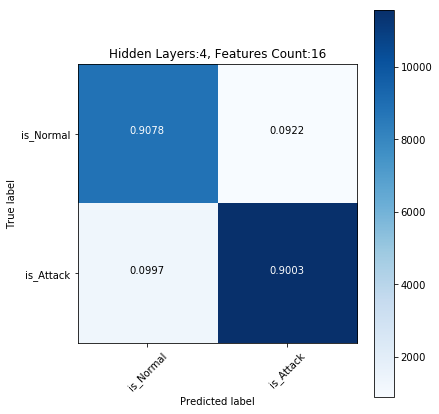

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.6636  0.3364]
 [ 0.1313  0.8687]]


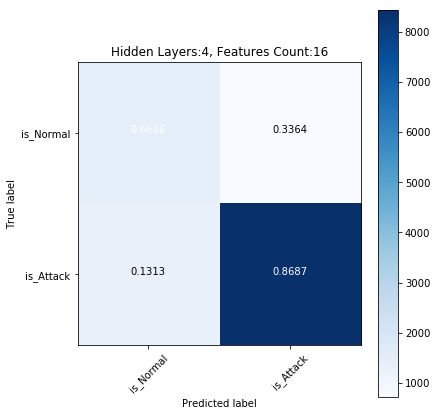

In [17]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)